In [1]:
import psycopg2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import plotly.graph_objects as go # type: ignore
import yfinance as yf # type: ignore
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir("../database")
list_ = os.listdir()

/Users/tp_mini/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [41]:
list_ = ["2219.HK", "1093.HK", "6030.HK", "0291.HK", "9961.HK", "6690.HK", "2313.HK", "1928.HK", "0005.HK", "0384.HK",
         "1113.HK", "0981.HK", "0006.HK", "0011.HK", "0003.HK", "1109.HK", "9633.HK", "2899.HK", "1398.HK", "0939.HK",
         "0027.HK", "0823.HK", "0001.HK", "1088.HK", "0386.HK", "0016.HK", "3968.HK", "0002.HK", "0669.HK", "3988.HK",
         "1171.HK", "9868.HK", "2269.HK", "1810.HK", "0700.HK", "2382.HK", "2386.HK", "2318.HK", "0992.HK", "1024.HK",
         "9618.HK", "0883.HK", "0388.HK", "0175.HK", "0941.HK", "2628.HK", "1211.HK", "2388.HK", "9888.HK", "2020.HK", "9988.HK", "1299.HK"]
df = yf.download(list_, start='2018-01-01')['Close']
df.to_parquet("hk_price_close.parquet")

[*********************100%***********************]  52 of 52 completed


In [39]:
import numpy as np

In [89]:
open = pd.read_parquet('hk_price_open.parquet')
close = pd.read_parquet('hk_price_close.parquet')
# ln = np.log(open.shift(0)/close.shift(1))
ln = np.log(close/open)
ln.head()
pct_for_profiting = close/open
pct_for_profiting = pct_for_profiting.shift(-3)

In [81]:
ln.iloc[-1].sort_values()

Ticker
0175.HK   -0.035915
9633.HK   -0.035591
2313.HK   -0.025686
9961.HK   -0.025485
0003.HK   -0.023218
6030.HK   -0.021303
1109.HK   -0.021277
0669.HK   -0.020933
2269.HK   -0.020203
2318.HK   -0.020060
2899.HK   -0.020014
1810.HK   -0.019636
6690.HK   -0.019570
0027.HK   -0.018898
2628.HK   -0.017367
0291.HK   -0.016950
1093.HK   -0.015855
9888.HK   -0.015475
1928.HK   -0.014453
0992.HK   -0.014108
1024.HK   -0.013505
9988.HK   -0.013293
0939.HK   -0.013072
0002.HK   -0.013062
0981.HK   -0.012980
0384.HK   -0.012520
2020.HK   -0.011689
0006.HK   -0.011606
0016.HK   -0.009852
1113.HK   -0.009245
1299.HK   -0.008193
1398.HK   -0.008000
3988.HK   -0.007682
3968.HK   -0.007290
0823.HK   -0.006173
2388.HK   -0.006030
9868.HK   -0.005172
0386.HK   -0.004695
0700.HK   -0.004165
1088.HK   -0.003257
0883.HK   -0.003197
0388.HK   -0.002730
1171.HK   -0.002506
0941.HK   -0.000666
1211.HK    0.001447
0005.HK    0.003160
9618.HK    0.003304
0001.HK    0.003757
2382.HK    0.005023
0011.HK    0.

<Axes: title={'center': '10 quantile cumsum distribution'}, xlabel='Date'>

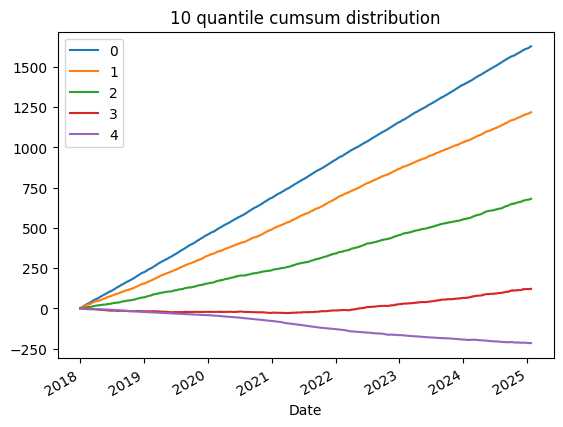

In [91]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
quantile = 5
# quantile = len(ln.columns)
time_length = len(ln)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = ln.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

pct_close_w_corres = pct_for_profiting[pct_for_profiting.columns.intersection(ln.columns)].shift(-2)

index = ln.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = ln.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
    weighting_1 = _reweighting_equal(df_1)
    ret = pct_close_w_corres.loc[weighting_1.index[0]:] * weighting_1
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()
quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.iloc[:, :10].plot(title="10 quantile cumsum distribution")

In [69]:
print(quantile_1)


0       [0001.HK]
1       [2382.HK]
2       [0883.HK]
3       [0291.HK]
4       [2382.HK]
          ...    
1732    [2899.HK]
1733    [0981.HK]
1734    [9618.HK]
1735    [0669.HK]
1736    [0981.HK]
Name: 0, Length: 1737, dtype: object


In [20]:
list_vars = []
for i in list_:
    test = df[[i]]
    test = test.pct_change()
    test = test.resample("ME").sum()
    test[i] = test.iloc[:, 0].rolling(5).std()*10
    list_vars.append(test[i])
df_var = pd.concat(list_vars, axis=1).dropna(how='all')

In [33]:
import plotly.graph_objects as go # type: ignore
from plotly.subplots import make_subplots
fig = go.Figure();
df_var_copy = df_var.iloc[-100:, :].copy()
list_sorted = list(df_var_copy.iloc[-1].sort_values(ascending=False).index)
df_var_copy.iloc[-1]
fig = make_subplots(
    rows=2, cols=1,  
    shared_xaxes=True,  
    vertical_spacing=0.1,  
    subplot_titles=["Cumulative Return", "Another Plot"],  
    row_heights=[0.7, 0.3]  
)
# for i in df_var_copy.columns[:]:
for i in list_sorted[:10]:
    temp = df_var_copy[i]
    fig.add_trace(go.Scatter(
        x=temp.index,
        y=temp.values,
        name=i,
        opacity=0.8,
        yaxis="y1"  # Assigning to the first y-axis
    ), row=1, col=1)


fig.show()

In [38]:
test = df[['0981.HK']]
test = test.pct_change()
test = test.resample("ME").sum()
test['var'] = test.iloc[:, 0].rolling(5).std()*10
test.iloc[:, 0] = test.iloc[:, 0].cumsum()

fig = go.Figure();
fig = make_subplots(
    rows=2, cols=1,  
    shared_xaxes=True,  
    vertical_spacing=0.1,  
    subplot_titles=["Cumulative Return", "Another Plot"],  
    row_heights=[0.7, 0.3]  
)
fig.add_trace(go.Scatter(
    x=test.iloc[:, 0].index,
    y=test.iloc[:, 0].values,
    name=i,
    opacity=0.8,
), row=1, col=1)

temp = df_var_copy[i]
fig.add_trace(go.Bar(
    x=test.iloc[:, 1].index,
    y=test.iloc[:, 1].values,
    name=i,
    opacity=0.8,
), row=2, col=1)

fig.show()